In [1]:
%pylab inline

from mpl_toolkits.axes_grid1 import ImageGrid

import scipy.ndimage as ndi
from scipy.signal import fftconvolve

%load_ext autoreload
%autoreload 2
from pyotf.otf import SheppardPSF, HanserPSF
from pyotf.utils import easy_fft, easy_ifft
import dphplotting as dplt
from dphutils import bin_ndarray, radial_profile

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.set_cmap("inferno");

<Figure size 432x288 with 0 Axes>

## Apotome

The technology behind the [Zeiss Apotome](https://www.zeiss.com/microscopy/us/products/imaging-systems/apotome-2-for-biology.html) was described by [Neil](https://www.osapublishing.org/abstract.cfm?URI=ol-22-24-1905) and [Wilson](http://www.sciencedirect.com/science/article/pii/S0030401898002107) over 20 years ago. While the math in the papers is opaque and difficult to understand the result can be summarized as follows: the Apotome PSF is similar to a light sheet PSF where the width of the light sheet is similar to the axial resolution of microscope and the axial profile is proportional to $J_1(z) / z$. Looking at the second publication the magic all happens when you can represent the effect of the grid pattern and post processing as an excitation PSF which is equivalent to $\exp(j\nu r)$ where $\nu$ is the frequency of the grating pattern and $r$ is the lateral coordinate along which it is aligned.

We can proceed with the simulation as before.

In [35]:
# We'll use a 1.27 NA water dipping objective imaging in water
psf_params = dict(
    na=1.27,
    ni=1.33,
    wl=0.561,
    size=128,
    vec_corr="none"
)

# Set the Nyquist sampling rate
nyquist_sampling = psf_params["wl"] / psf_params["na"] / 4

# our oversampling factor, must be odd for easy integration (for peaked symmetrical funtions the kernel must be odd)
oversample_factor = 3

# Over sample to 
psf_params["res"] = nyquist_sampling * 0.99 / oversample_factor
psf_params["size"] *= oversample_factor

In [44]:
# plot function 😬
def easy_plot(psfs, labels):
    ncols = len(psfs)
    
    assert ncols == len(labels), "Lengths mismatched"
    assert ncols < 10
    
    plot_size = 2.0
    
    fig = plt.figure(None, (plot_size * ncols, plot_size * 4), dpi=150)
    grid = ImageGrid(fig, 111, nrows_ncols=(4, ncols), axes_pad=0.1)
    
    
    fig2, axp = plt.subplots(dpi=150, figsize=(plot_size * ncols, 4))
    
    for (i, p), l, col in zip(enumerate(psfs), labels, grid.axes_column):
#         p = bin_ndarray(p, bin_size=oversample_factor)
        p /= p.max()
        col[0].imshow(p.max(1), norm = mpl.colors.PowerNorm(0.3), interpolation='bicubic')
        col[1].imshow(p.max(0), norm = mpl.colors.PowerNorm(0.3), interpolation='bicubic')
        
        col[0].set_title(l)

        otf = abs(easy_fft(p))
        otf /= otf.max()
        otf = np.fmax(otf, 1e-3)
        c = (len(otf) + 1) // 2
        
        col[2].matshow(otf[:, c], norm=mpl.colors.LogNorm(), interpolation='bicubic')
        col[3].matshow(otf[c], norm=mpl.colors.LogNorm(), interpolation='bicubic')
        
        pp = p[:, c, c]
        axp.plot((np.arange(len(pp)) - (len(pp) + 1) // 2) * psf_params["res"], pp / pp.max(), label=l)
    
    
    for ax in grid:
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        
    ylabels = "XZ", "XY"
    ylabels += tuple(map(lambda x: r"$k_{{{}}}$".format(x), ylabels))
    for ax, l in zip(grid.axes_column[0], ylabels):
        ax.set_ylabel(l)
    
    axp.yaxis.set_major_locator(plt.NullLocator())
    axp.set_xlabel("Axial Position (µm)")
    axp.set_title("On Axis Intensity")
    axp.legend()

In [37]:
# calculate 3D
psf_det = SheppardPSF(**psf_params).PSFi

In [38]:
psf_det.shape

(384, 384, 384)

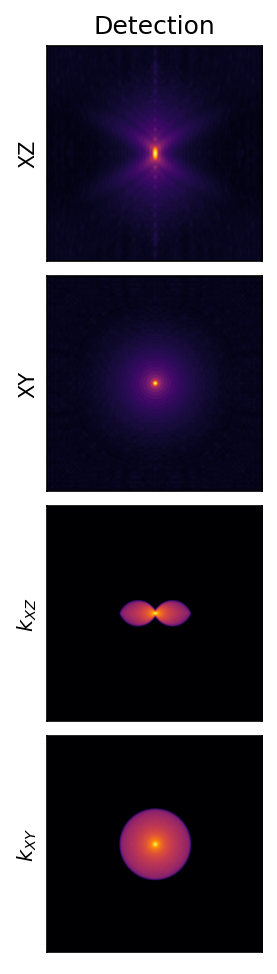

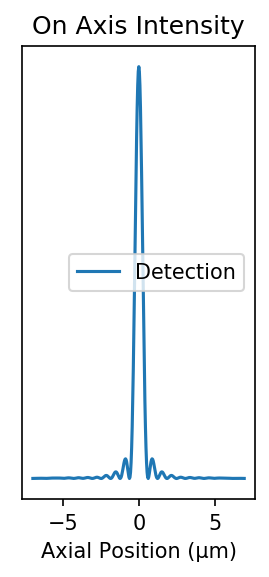

In [45]:
easy_plot((psf_det, ), ("Detection", ))

In [46]:
otf_det = abs(easy_fft(psf_det))

In [47]:
num_pixels = len(psf_det)
x = np.arange(num_pixels) * 1.0 - (num_pixels + 1) // 2
x *= psf_params["res"]

In [62]:
abbe_frequency = 1 / nyquist_sampling / 2

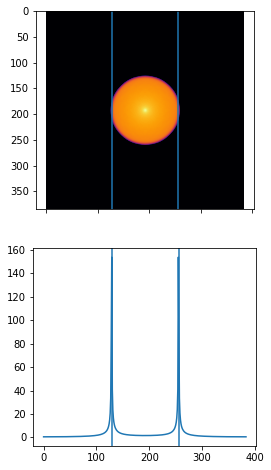

In [66]:
fig, (ax_mat, ax_plot) = plt.subplots(2, sharex=True, figsize=(4, 8))
ax_mat.imshow(np.fmax(1e-3, otf_det[(num_pixels + 1) // 2]), norm=mpl.colors.LogNorm(), interpolation='bicubic')
ax_plot.plot(abs(easy_fft(cos(2 * pi * abbe_frequency * x))))
for ax in (ax_mat, ax_plot):
    ax.axvline((num_pixels + 1) // 2 + abbe_frequency * psf_params["res"] * num_pixels)
    ax.axvline((num_pixels + 1) // 2 - abbe_frequency * psf_params["res"] * num_pixels)

In [68]:
psf_exc = exp(2j * pi * abbe_frequency * x / 2)

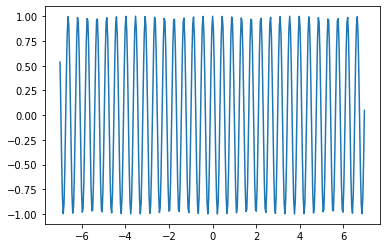

In [70]:
plt.plot(x, psf_exc.real)

In [74]:
psf_apo = fftconvolve(psf_det, psf_exc[None, :, None], "same", axes=1)

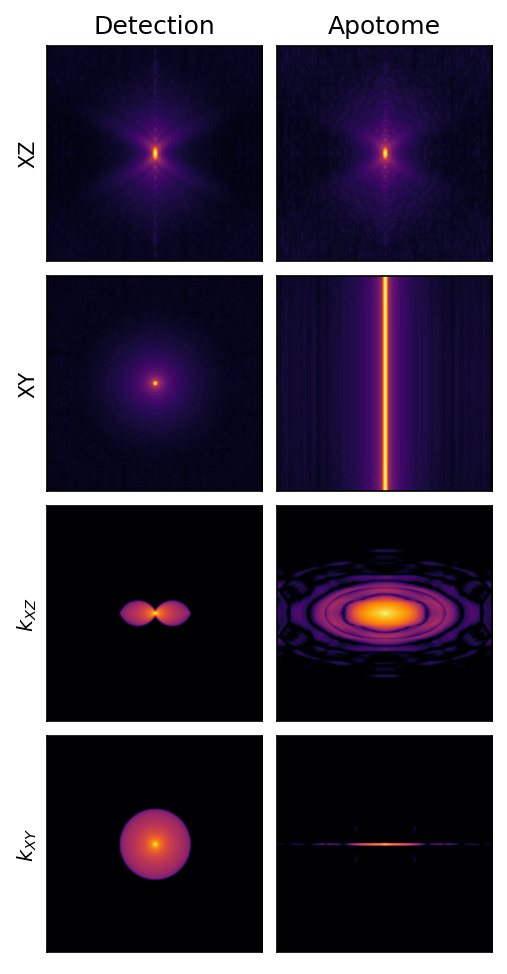

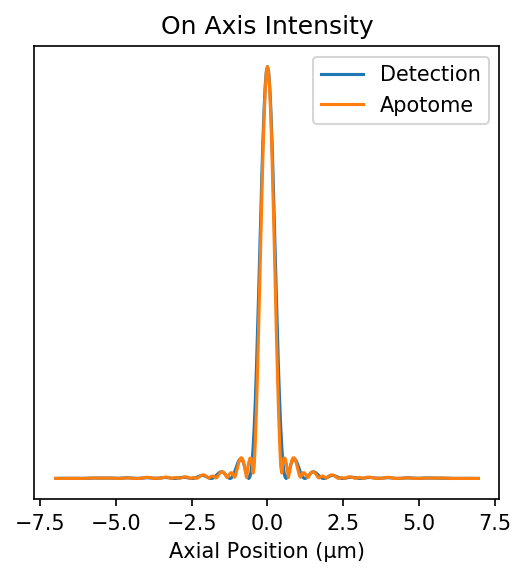

In [75]:
easy_plot((psf_det, abs(psf_apo)), ("Detection", "Apotome"))